### Correcting shifted longitude frames and subsequent xESMF-remapping

Datasets not defined on the longitude intervals [0, 360] and [-180, 180], but shifted to eg. [-300, 60] need to be corrected before xESMF can deal with them. Does this introduce any unforseen problems?

#### Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import xarray as xr
import cf_xarray as cfxr
import xesmf as xe
from pathlib import Path
from git import Repo
import os

import clisops as cl
import clisops.ops as clops
import clisops.core as clore
from clisops.utils import dataset_utils as clidu
from roocs_grids import get_grid_file, grid_dict, grid_annotations

xr.set_options(display_style='html');

## Turn off warnings?
#import warnings
#warnings.simplefilter("ignore")

print(f"Using cf_xarray in version {cfxr.__version__}")
print(f"Using xESMF in version {xe.__version__}")
print(f"Using clisops in version {cl.__version__}")

Using cf_xarray in version 0.7.0
Using xESMF in version 0.6.3.dev2+g7b8ce9d
Using clisops in version 0.8.0


#### Initialize test data

In [2]:
# Initialize mini-esgf-data
MINIESGF_URL="https://github.com/roocs/mini-esgf-data"
branch = "master"
MINIESGF = Path(Path.home(),".mini-esgf-data", branch)

# Retrieve mini-esgf test data
if not os.path.isdir(MINIESGF):
    repo = Repo.clone_from(MINIESGF_URL, MINIESGF)
    repo.git.checkout(branch)
else:
    repo = Repo(MINIESGF)
    repo.git.checkout(branch)
    repo.remotes[0].pull()
    
MINIESGF=Path(MINIESGF,"test_data")

#### Load the dataset

In [3]:
ds_path = Path(MINIESGF, "badc/cmip6/data/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/historical/r1i1p1f1",
                         "Omon/sos/gn/v20180701/sos_Omon_GFDL-CM4_historical_r1i1p1f1_gn_185001.nc")
ds = xr.open_dataset(ds_path)
ds

<xarray.Dataset>
Dimensions:    (y: 1080, x: 1440, vertex: 4, time: 1, bnds: 2)
Coordinates:
    lat        (y, x) float32 ...
    lon        (y, x) float32 ...
  * time       (time) object 1850-01-16 12:00:00
  * x          (x) float64 -299.7 -299.5 -299.2 -299.0 ... 59.53 59.78 60.03
  * y          (y) float64 -80.39 -80.31 -80.23 -80.15 ... 89.73 89.84 89.95
Dimensions without coordinates: vertex, bnds
Data variables:
    lat_bnds   (y, x, vertex) float32 ...
    lon_bnds   (y, x, vertex) float32 ...
    sos        (time, y, x) float32 ...
    time_bnds  (time, bnds) object ...
Attributes: (12/47)
    title:                  NOAA GFDL GFDL-CM4 model output prepared for CMIP...
    external_variables:     areacello
    history:                Wed Feb 23 15:36:16 2022: ncks -L 9 -d time,0 --v...
    table_id:               Omon
    activity_id:            CMIP
    branch_method:          standard
    ...                     ...
    variant_info:           N/A
    references:             see further_info_url attribute
    variant_label:          r1i1p1f1
    branch_time_in_parent:  36500.0
    parent_time_units:      days since 0001-1-1
    NCO:                    4.7.2

#### Take a look at the grid

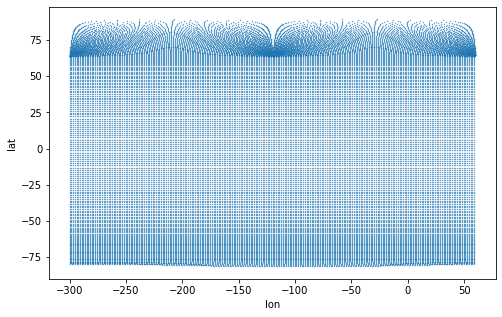

In [4]:
plt.figure(figsize=(8,5))
plt.scatter(ds['lon'][::6, ::6], ds['lat'][::6, ::6], s=0.1)  
plt.xlabel('lon');
plt.ylabel('lat');

#### Correct shifted longitude frame in multiple ways

- Using `clisops.utils.dataset_utils.cf_convert_between_lon_frames` to correct the shift and re-sort the coordinates

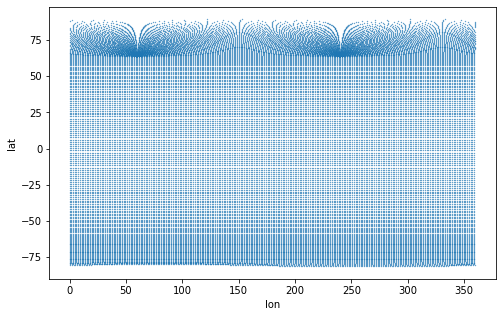

In [5]:
ds_conv_360 = clidu.cf_convert_between_lon_frames(ds,(0,360))[0]
ds_conv_360 = clore.Grid(ds=ds_conv_360).ds

plt.figure(figsize=(8,5))
plt.scatter(ds_conv_360['lon'][::6, ::6], ds_conv_360['lat'][::6, ::6], s=0.1)  
plt.xlabel('lon');
plt.ylabel('lat');

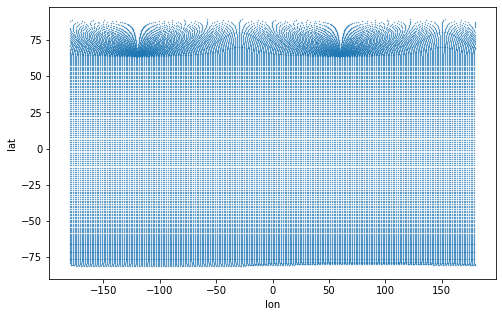

In [6]:
ds_conv_180 = clidu.cf_convert_between_lon_frames(ds,(-180,180))[0]
ds_conv_180 = clore.Grid(ds=ds_conv_180).ds

plt.figure(figsize=(8,5))
plt.scatter(ds_conv_180['lon'][::6, ::6], ds_conv_180['lat'][::6, ::6], s=0.1)  
plt.xlabel('lon');
plt.ylabel('lat');

- Simply adding 300 to each `lon` and `lon_bnds` value and substracting 300 after the remapping (latter step is left out here), to leave the sorting of the coordinate variables intact

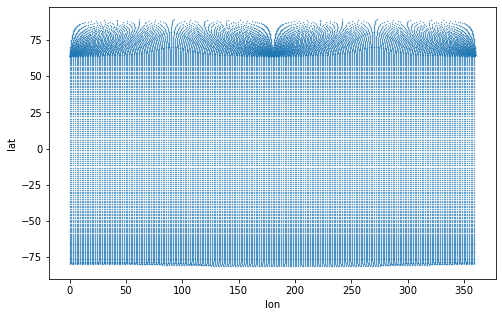

In [7]:
ds_add_300 = ds.copy()
ds_add_300['lon'] = ds_add_300['lon']+300.
ds_add_300['lon_bnds'] = ds_add_300['lon_bnds']+300.
ds_add_300['lon'].attrs = ds['lon'].attrs
ds_add_300 = clore.Grid(ds=ds_add_300).ds

plt.figure(figsize=(8,5))
plt.scatter(ds_add_300['lon'][::6, ::6], ds_add_300['lat'][::6, ::6], s=0.1)  
plt.xlabel('lon');
plt.ylabel('lat');

#### Generate remapping weights

In [8]:
def regrid(ds_in, ds_out, method, periodic=False):
    """Convenience function for calculating regridding weights"""
    return xe.Regridder(ds_in, ds_out, method, periodic=periodic, unmapped_to_nan=True, ignore_degenerate=True)

In [9]:
# Target grid
ds_out = clore.Grid(grid_instructor=1).ds

In [10]:
# method_list = ['bilinear','nearest_s2d', 'conservative', 'conservative_normed', 'patch']
method_list = ['conservative']
#method_list = ['bilinear']
regridder = {}
for method in method_list:
    print()
    %time regridder[method+"_conv_360"]=regrid(ds_conv_360, ds_out, method)
    print(regridder[method+"_conv_360"])
    
    print()
    %time regridder[method+"_conv_180"]=regrid(ds_conv_180, ds_out, method)
    print(regridder[method+"_conv_180"])
    
    print()
    %time regridder[method+"_add_300"]=regrid(ds_add_300, ds_out, method)
    print(regridder[method+"_add_300"])
    
    print()
    %time regridder[method+"_conv_360_peri"]=regrid(ds_conv_360, ds_out, method, True)
    print(regridder[method+"_conv_360_peri"])
    
    print()
    %time regridder[method+"_conv_180_peri"]=regrid(ds_conv_180, ds_out, method, True)
    print(regridder[method+"_conv_180_peri"])
    
    print()
    %time regridder[method+"_add_300_peri"]=regrid(ds_add_300, ds_out, method, True)
    print(regridder[method+"_add_300_peri"]) 


CPU times: user 26.1 s, sys: 526 ms, total: 26.6 s
Wall time: 26.6 s
xESMF Regridder 
Regridding algorithm:       conservative 
Weight filename:            conservative_1080x1440_180x360.nc 
Reuse pre-computed weights? False 
Input grid shape:           (1080, 1440) 
Output grid shape:          (180, 360) 
Periodic in longitude?      False

CPU times: user 25.7 s, sys: 291 ms, total: 26 s
Wall time: 26 s
xESMF Regridder 
Regridding algorithm:       conservative 
Weight filename:            conservative_1080x1440_180x360.nc 
Reuse pre-computed weights? False 
Input grid shape:           (1080, 1440) 
Output grid shape:          (180, 360) 
Periodic in longitude?      False

CPU times: user 25.5 s, sys: 267 ms, total: 25.7 s
Wall time: 25.7 s
xESMF Regridder 
Regridding algorithm:       conservative 
Weight filename:            conservative_1080x1440_180x360.nc 
Reuse pre-computed weights? False 
Input grid shape:           (1080, 1440) 
Output grid shape:          (180, 360) 
Periodic 

#### Remapping

In [11]:
for method in method_list:
    ds_out["sos_"+method+"_conv_360"]=regridder[method+"_conv_360"](ds_conv_360.sos)
    ds_out["sos_"+method+"_conv_180"]=regridder[method+"_conv_180"](ds_conv_180.sos)
    ds_out["sos_"+method+"_add_300"]=regridder[method+"_add_300"](ds_add_300.sos)
    ds_out["sos_"+method+"_conv_360_skipna"]=regridder[method+"_conv_360"](ds_conv_360.sos, skipna=True)
    ds_out["sos_"+method+"_conv_180_skipna"]=regridder[method+"_conv_180"](ds_conv_180.sos, skipna=True)
    ds_out["sos_"+method+"_add_300_skipna"]=regridder[method+"_add_300"](ds_add_300.sos, skipna=True)
    ds_out["sos_"+method+"_conv_360_peri"]=regridder[method+"_conv_360_peri"](ds_conv_360.sos)
    ds_out["sos_"+method+"_conv_180_peri"]=regridder[method+"_conv_180_peri"](ds_conv_180.sos)
    ds_out["sos_"+method+"_add_300_peri"]=regridder[method+"_add_300_peri"](ds_add_300.sos)
ds_out

<xarray.Dataset>
Dimensions:                           (lat: 180, lon: 360, bnds: 2, time: 1)
Coordinates:
  * lat                               (lat) float64 -89.5 -88.5 ... 88.5 89.5
  * lon                               (lon) float64 -179.5 -178.5 ... 179.5
    lat_bnds                          (lat, bnds) float64 -90.0 -89.0 ... 90.0
    lon_bnds                          (lon, bnds) float64 -180.0 ... 180.0
  * time                              (time) object 1850-01-16 12:00:00
Dimensions without coordinates: bnds
Data variables:
    sos_conservative_conv_360         (time, lat, lon) float32 nan nan ... 32.41
    sos_conservative_conv_180         (time, lat, lon) float32 nan nan ... 32.41
    sos_conservative_add_300          (time, lat, lon) float32 nan nan ... 32.6
    sos_conservative_conv_360_skipna  (time, lat, lon) float64 nan nan ... 32.41
    sos_conservative_conv_180_skipna  (time, lat, lon) float64 nan nan ... 32.41
    sos_conservative_add_300_skipna   (time, lat, lon) float64 nan nan ... 32.6
    sos_conservative_conv_360_peri    (time, lat, lon) float32 nan nan ... 32.41
    sos_conservative_conv_180_peri    (time, lat, lon) float32 nan nan ... 32.41
    sos_conservative_add_300_peri     (time, lat, lon) float32 nan nan ... 32.6

#### Plot

Qualitatively it looks as everything worked properly. There are however columns of low values in the remapped data, where the left and right bounds of the curvilinear grid touch, which disappear when activating the `periodic_in_longitude` option of xESMF. To activate this option for the `conservative` remapping method, the xESMF code has to be modified (issue [#28](https://github.com/pangeo-data/xESMF/issues/28)). Similar result can be achieved when applying a renormalization (`conservative_normed` method or active `skipna` option).

##### Plot - non-periodic case

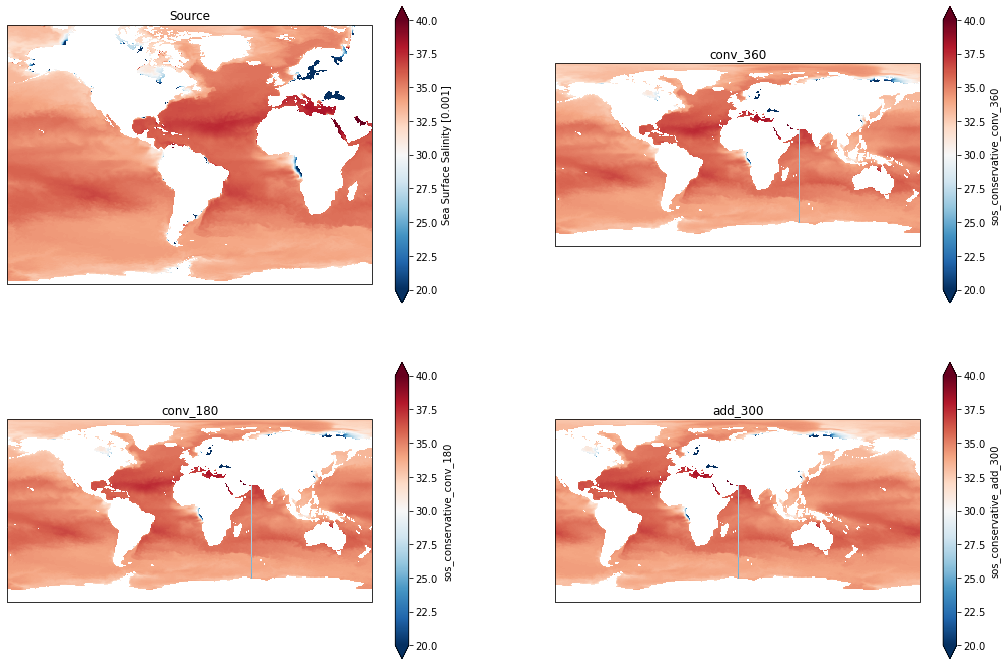

In [12]:
# Create panel plot of regridded data (global)
method = method_list[-1]
fig, axes = plt.subplots(ncols=2, nrows=2, 
                         figsize=(18, 12), # global
                         subplot_kw={'projection': ccrs.PlateCarree()})

ds['sos'].isel(time=0).plot.pcolormesh(ax=axes[0,0], vmin=20, vmax=40, cmap="RdBu_r");
axes[0,0].title.set_text("Source");
ds_out["sos_"+method+"_conv_360"].isel(time=0).plot.pcolormesh(ax=axes[0,1], vmin=20, vmax=40, cmap="RdBu_r");
axes[0,1].title.set_text("conv_360");
ds_out["sos_"+method+"_conv_180"].isel(time=0).plot.pcolormesh(ax=axes[1,0], vmin=20, vmax=40, cmap="RdBu_r");
axes[1,0].title.set_text("conv_180");
ds_out["sos_"+method+"_add_300"].isel(time=0).plot.pcolormesh(ax=axes[1,1], vmin=20, vmax=40, cmap="RdBu_r");
axes[1,1].title.set_text("add_300");

for axis in axes.flatten():
    #axis.coastlines();
    axis.set_xlabel('lon');
    axis.set_ylabel('lat');
    #axis.set_xlim([-10, 10]);
    #axis.set_ylim([-30, 30]);

##### Plot - periodic case

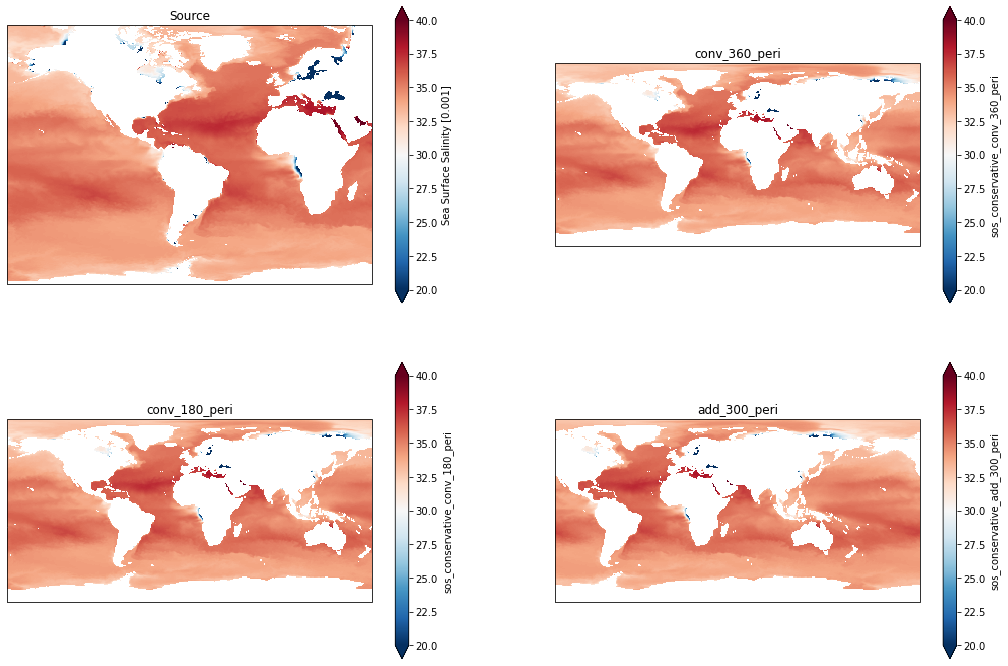

In [13]:
# Create panel plot of regridded data (global) - periodic
method = method_list[-1]
fig, axes = plt.subplots(ncols=2, nrows=2, 
                         figsize=(18, 12), # global
                         subplot_kw={'projection': ccrs.PlateCarree()})

ds['sos'].isel(time=0).plot.pcolormesh(ax=axes[0,0], vmin=20, vmax=40, cmap="RdBu_r");
axes[0,0].title.set_text("Source");
ds_out["sos_"+method+"_conv_360_peri"].isel(time=0).plot.pcolormesh(ax=axes[0,1], vmin=20, vmax=40, cmap="RdBu_r");
axes[0,1].title.set_text("conv_360_peri");
ds_out["sos_"+method+"_conv_180_peri"].isel(time=0).plot.pcolormesh(ax=axes[1,0], vmin=20, vmax=40, cmap="RdBu_r");
axes[1,0].title.set_text("conv_180_peri");
ds_out["sos_"+method+"_add_300_peri"].isel(time=0).plot.pcolormesh(ax=axes[1,1], vmin=20, vmax=40, cmap="RdBu_r");
axes[1,1].title.set_text("add_300_peri");

for axis in axes.flatten():
    #axis.coastlines();
    axis.set_xlabel('lon');
    axis.set_ylabel('lat');
    #axis.set_xlim([-10, 10]);
    #axis.set_ylim([-30, 30]);

##### Plot - non-periodic + skipna

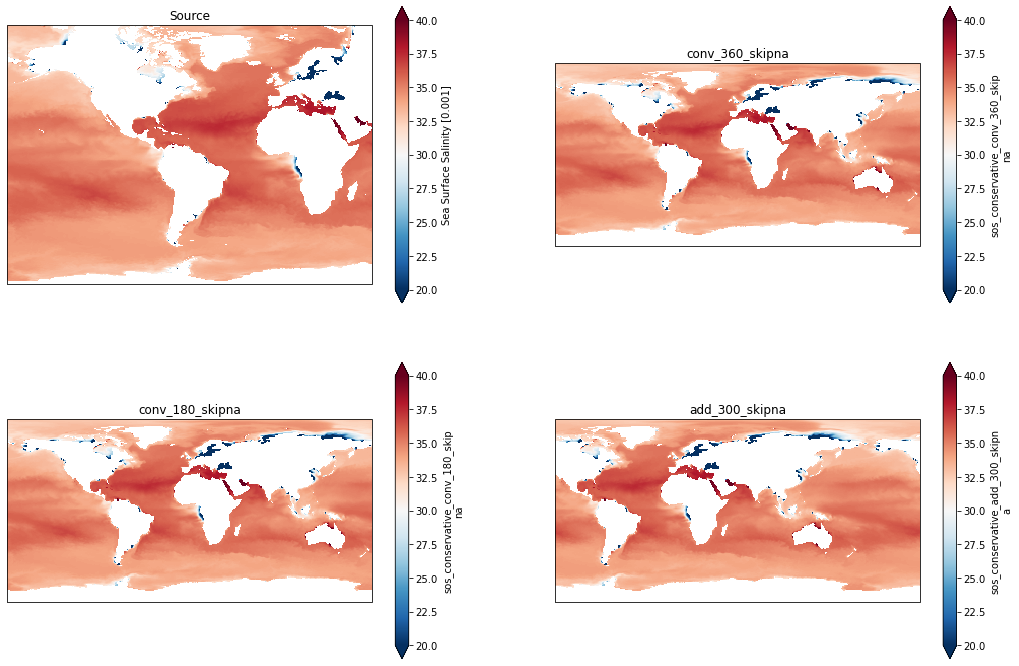

In [14]:
# Create panel plot of regridded data (global) - non-periodic + skipna
method = method_list[-1]
fig, axes = plt.subplots(ncols=2, nrows=2, 
                         figsize=(18, 12), # global
                         subplot_kw={'projection': ccrs.PlateCarree()})

ds['sos'].isel(time=0).plot.pcolormesh(ax=axes[0,0], vmin=20, vmax=40, cmap="RdBu_r");
axes[0,0].title.set_text("Source");
ds_out["sos_"+method+"_conv_360_skipna"].isel(time=0).plot.pcolormesh(ax=axes[0,1], vmin=20, vmax=40, cmap="RdBu_r");
axes[0,1].title.set_text("conv_360_skipna");
ds_out["sos_"+method+"_conv_180_skipna"].isel(time=0).plot.pcolormesh(ax=axes[1,0], vmin=20, vmax=40, cmap="RdBu_r");
axes[1,0].title.set_text("conv_180_skipna");
ds_out["sos_"+method+"_add_300_skipna"].isel(time=0).plot.pcolormesh(ax=axes[1,1], vmin=20, vmax=40, cmap="RdBu_r");
axes[1,1].title.set_text("add_300_skipna");

for axis in axes.flatten():
    #axis.coastlines();
    axis.set_xlabel('lon');
    axis.set_ylabel('lat');
    #axis.set_xlim([-10, 10]);
    #axis.set_ylim([-30, 30]);

#### Differences

In [15]:
ds_out["sos_"+method+"_conv_360_diff"] = ds_out["sos_"+method+"_conv_360_peri"] - ds_out["sos_"+method+"_conv_360"]
ds_out["sos_"+method+"_conv_180_diff"] = ds_out["sos_"+method+"_conv_180_peri"] - ds_out["sos_"+method+"_conv_180"]
ds_out["sos_"+method+"_add_300_diff"] = ds_out["sos_"+method+"_add_300_peri"] - ds_out["sos_"+method+"_add_300"]

ds_out["sos_"+method+"_conv_360_diffna"] = ds_out["sos_"+method+"_conv_360_peri"] - ds_out["sos_"+method+"_conv_360_skipna"]
ds_out["sos_"+method+"_conv_180_diffna"] = ds_out["sos_"+method+"_conv_180_peri"] - ds_out["sos_"+method+"_conv_180_skipna"]
ds_out["sos_"+method+"_add_300_diffna"] = ds_out["sos_"+method+"_add_300_peri"] - ds_out["sos_"+method+"_add_300_skipna"]

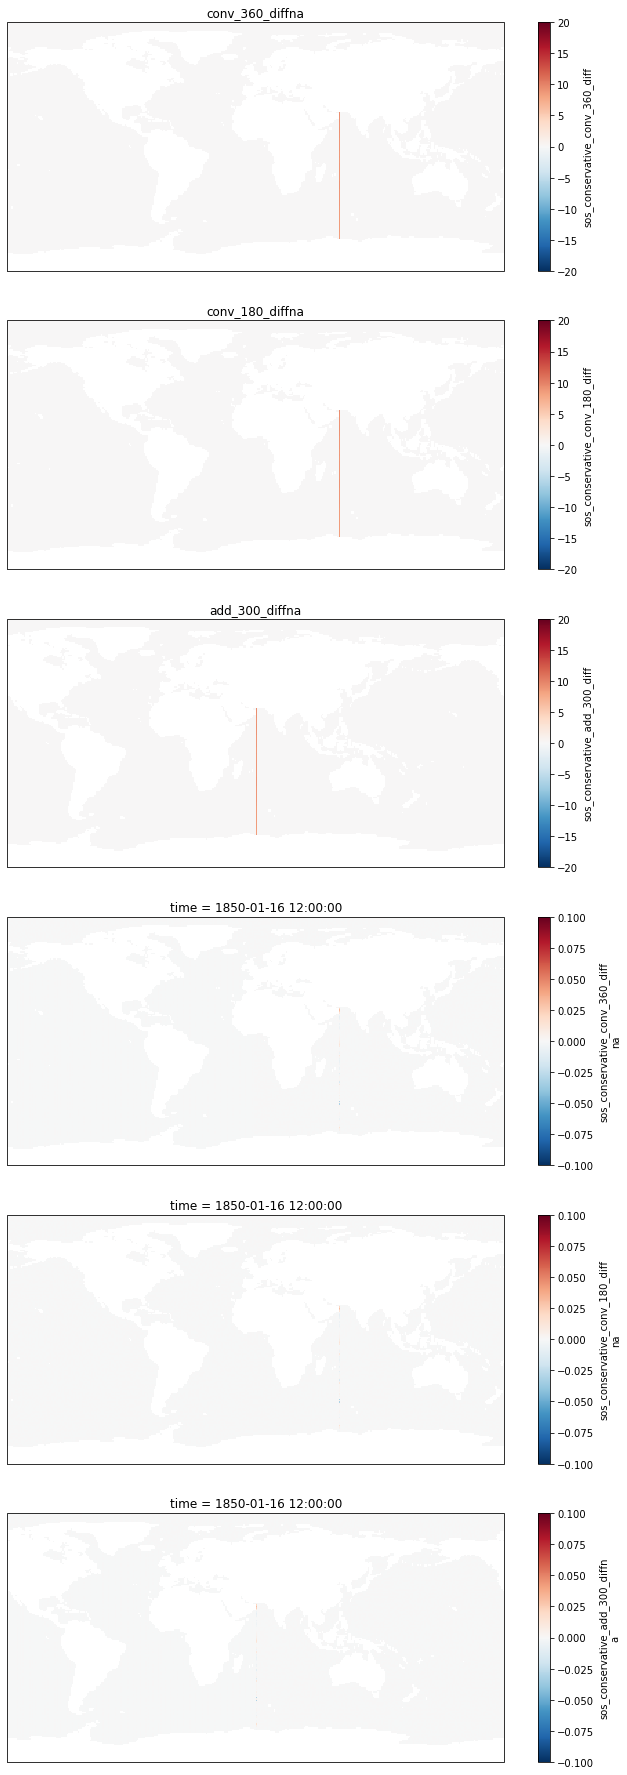

In [16]:
# Create panel plot of difference between regridded datasets (global)
method = method_list[-1]
fig, axes = plt.subplots(ncols=1, nrows=6, 
                         figsize=(12, 32), # global
                         subplot_kw={'projection': ccrs.PlateCarree()})

ds_out["sos_"+method+"_conv_360_diff"].isel(time=0).plot.pcolormesh(ax=axes[0], vmin=-20, vmax=20, cmap="RdBu_r");
axes[0].title.set_text("conv_360_diff");
ds_out["sos_"+method+"_conv_180_diff"].isel(time=0).plot.pcolormesh(ax=axes[1], vmin=-20, vmax=20, cmap="RdBu_r");
axes[1].title.set_text("conv_180_diff");
ds_out["sos_"+method+"_add_300_diff"].isel(time=0).plot.pcolormesh(ax=axes[2], vmin=-20, vmax=20, cmap="RdBu_r");
axes[2].title.set_text("add_300_diff");
ds_out["sos_"+method+"_conv_360_diffna"].isel(time=0).plot.pcolormesh(ax=axes[3], vmin=-.1, vmax=.1, cmap="RdBu_r");
axes[0].title.set_text("conv_360_diffna");
ds_out["sos_"+method+"_conv_180_diffna"].isel(time=0).plot.pcolormesh(ax=axes[4], vmin=-.1, vmax=.1, cmap="RdBu_r");
axes[1].title.set_text("conv_180_diffna");
ds_out["sos_"+method+"_add_300_diffna"].isel(time=0).plot.pcolormesh(ax=axes[5], vmin=-.1, vmax=.1, cmap="RdBu_r");
axes[2].title.set_text("add_300_diffna");

for axis in axes.flatten():
    #axis.coastlines();
    axis.set_xlabel('lon');
    axis.set_ylabel('lat');
    #axis.set_xlim([-10, 10]);
    #axis.set_ylim([-30, 30]);